In [1]:
import codecs
import copy
import gc
import json
import logging
import os
import pickle
import random
import time
from typing import List, Tuple, Union
import xarray as xr

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
import tensorflow as tf
from tensorflow.python.framework import tensor_util
from tensorflow.python.keras.utils import losses_utils, tf_utils
from tensorflow.python.ops.losses import util as tf_losses_util
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import umap

In [4]:
from assessment import calc_uncertainty_regection_curve, f_beta_metrics
from uncertainty import ensemble_uncertainties_regression

In [5]:
class LossFunctionWrapper(tf.keras.losses.Loss):
    def __init__(self,
                 fn,
                 reduction=losses_utils.ReductionV2.AUTO,
                 name=None,
                 **kwargs):
        super(LossFunctionWrapper, self).__init__(reduction=reduction, name=name)
        self.fn = fn
        self._fn_kwargs = kwargs

    def call(self, y_true, y_pred):
        if tensor_util.is_tensor(y_pred) and tensor_util.is_tensor(y_true):
            y_pred, y_true = tf_losses_util.squeeze_or_expand_dimensions(y_pred, y_true)
        return self.fn(y_true, y_pred, **self._fn_kwargs)

    def get_config(self):
        config = {}
        for k, v in six.iteritems(self._fn_kwargs):
            config[k] = tf.keras.backend.eval(v) if tf_utils.is_tensor_or_variable(v) \
                else v
        base_config = super(LossFunctionWrapper, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
def npairs_loss(labels, feature_vectors):
    feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
    logits = tf.divide(
        tf.matmul(
            feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
        ),
        0.5  # temperature
    )
    return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [7]:
class NPairsLoss(LossFunctionWrapper):
    def __init__(self, reduction=losses_utils.ReductionV2.AUTO,
                 name='m_pairs_loss'):
        super(NPairsLoss, self).__init__(npairs_loss, name=name,
                                         reduction=reduction)

In [8]:
def build_preprocessor(X: np.ndarray, colnames: List[str]) -> Pipeline:
    X_ = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'scaler',
            MinMaxScaler()
        )
    ]).fit_transform(X)
    X_ = np.rint(X_ * 100000.0).astype(np.int32)
    binary_features = dict()
    categorical_features = dict()
    removed_features = []
    for col_idx in range(X.shape[1]):
        values = set(X_[:, col_idx].tolist())
        print(f'Column {col_idx} "{colnames[col_idx]}" has ' \
              f'{len(values)} unique values.')
        if len(values) > 1:
            if len(values) < 3:
                binary_features[col_idx] = np.min(X[:, col_idx])
            else:
                categorical_features[col_idx] = len(values)
        else:
            removed_features.append(col_idx)
        del values
    del X_
    all_features = set(range(X.shape[1]))
    useful_features = sorted(list(all_features - set(removed_features)))
    if len(useful_features) == 0:
        raise ValueError('Training inputs are bad. All features are removed.')
    print(f'There are {X.shape[1]} features.')
    if len(removed_features) > 0:
        print(f'These features will be removed: ' \
              f'{[colnames[col_idx] for col_idx in removed_features]}.')
    transformers = []
    if (len(categorical_features) > 0) and (len(binary_features) > 0):
        print(f'There are {len(categorical_features)} categorical ' \
              f'features and {len(binary_features)} binary features.')
    elif len(categorical_features) > 0:
        print(f'There are {len(categorical_features)} categorical features.')
    else:
        print(f'There are {len(binary_features)} binary features.')
    for col_idx in categorical_features:
        n_unique_values = categorical_features[col_idx]
        transformers.append(
            (
                colnames[col_idx],
                KBinsDiscretizer(
                    n_bins=min(max(n_unique_values // 3, 3), 256),
                    encode='ordinal',
                    strategy=('quantile' if n_unique_values > 50 else 'kmeans')
                ),
                (col_idx,)
            )
        )
    for col_idx in binary_features:
        transformers.append(
            (
                colnames[col_idx],
                Binarizer(threshold=0.0),
                (col_idx,)
            )
        )
    preprocessor = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'minmax_scaler',
            MinMaxScaler()
        ),
        (
            'composite_transformer', ColumnTransformer(
                transformers=transformers,
                sparse_threshold=0.0,
                n_jobs=1
            )
        ),
        (
            'selector',
            VarianceThreshold()
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42)
        )
    ])
    return preprocessor.fit(X)

In [9]:
def reduce_dimensions_of_data(features: np.ndarray) -> np.ndarray:
    preprocessed_features = Pipeline(
        steps=[
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=features.shape[1] // 3,
                        random_state=42))
        ]
    ).fit_transform(features)
    print('Features are preprocessed.')
    reduced_features = umap.UMAP(
        low_memory=False,
        n_jobs=-1,
        random_state=42,
        verbose=True
    ).fit_transform(preprocessed_features)
    print('Feature space is reduced.')
    del preprocessed_features
    return reduced_features

In [10]:
def show_temperature(features: np.ndarray, targets: np.ndarray,
                     title: str='', figure_id: int=0):
    if features.shape[0] != targets.shape[0]:
        err_msg = f'Features do not correspond to targets! ' \
                  f'{features.shape[0]} != {targets.shape[0]}'
        raise ValueError(err_msg)
    if len(features.shape) != 2:
        err_msg = f'Features are wrong! Expected 2-D array, got ' \
                  f'{len(features.shape)}-D one.'
        raise ValueError(err_msg)
    if features.shape[1] != 2:
        err_msg = f'Features are wrong! Expected number of ' \
                  f'columns is 2, got {features.shape[1]}.'
        raise ValueError(err_msg)
    if len(targets.shape) != 1:
        err_msg = f'Targets are wrong! Expected 1-D array, got ' \
                  f'{len(targets.shape)}-D one.'
        raise ValueError(err_msg)
    sorted_targets = sorted(targets.tolist())
    n_percentile2 = max(int(round(0.01 * len(sorted_targets))), 1)
    min_target = sorted_targets[n_percentile2]
    max_target = sorted_targets[-n_percentile2]
    del sorted_targets
    clipped_targets = np.empty(targets.shape, dtype=np.float64)
    for sample_idx in range(targets.shape[0]):
        if targets[sample_idx] < min_target:
            clipped_targets[sample_idx] = min_target
        elif targets[sample_idx] > max_target:
            clipped_targets[sample_idx] = max_target
        else:
            clipped_targets[sample_idx] = targets[sample_idx]
    temperature_colors = clipped_targets.tolist()
    temperature_norm = Normalize(vmin=np.min(temperature_colors),
                                 vmax=np.max(temperature_colors))
    fig = plt.figure(figure_id, figsize=(11, 11))
    plt.scatter(x=features[:, 0], y=features[:, 1],
                marker='o', cmap=plt.cm.get_cmap("jet"), c=temperature_colors,
                norm=temperature_norm)
    if len(title) > 0:
        plt.title(f'UMAP projections of weather data {title} (temperature)')
    else:
        plt.title(f'UMAP projections of weather data (temperature)')
    plt.colorbar()
    plt.show()

In [11]:
def filter_dataset(y: np.ndarray) -> List[int]:
    all_values = sorted(y.tolist())
    n = len(all_values)
    if n <= 10000:
        err_msg = f'y is wrong! Expected length of y is greater than 10000, ' \
                  f'but got {n}.'
        raise ValueError(err_msg)
    y001 = all_values[int(round((n - 1) * 0.001))]
    y999 = all_values[int(round((n - 1) * 0.999))]
    del all_values
    filtered_indices = list(filter(
        lambda idx: (y[idx] > y001) and (y[idx] < y999),
        range(n)
    ))
    return filtered_indices

In [12]:
def build_neural_network(input_size: int, layer_size: int, n_layers: int,
                         dropout_rate: float, scale_coeff: float,
                         nn_name: str) -> tf.keras.Model:
    feature_vector = tf.keras.layers.Input(
        shape=(input_size,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    outputs = []
    hidden_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_dropout1'
    )(feature_vector)
    for layer_idx in range(1, (2 * n_layers) // 3 + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    projection_layer = tf.keras.layers.Dense(
        units=50,
        activation=None,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_projection'
    )(hidden_layer)
    for layer_idx in range((2 * n_layers) // 3 + 1, n_layers + 1):
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        hidden_layer = tf.keras.layers.Dense(
            units=layer_size,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dense{layer_idx}'
        )(hidden_layer)
        hidden_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dropout{layer_idx + 1}'
        )(hidden_layer)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    output_layer = tf.keras.layers.Dense(
        units=2,
        activation=None,
        use_bias=False,
        kernel_initializer=kernel_initializer,
        name=f'{nn_name}_output'
    )(hidden_layer)
    bayesian_layer = tfp.layers.DistributionLambda(
        lambda t: tfp.distributions.Normal(
            loc=t[..., :1],
            scale=1e-6 + tf.math.softplus((1.0 / scale_coeff) * t[..., 1:])
        ),
        name=f'{nn_name}_distribution'
    )(output_layer)
    neural_network = tf.keras.Model(
        inputs=feature_vector,
        outputs=[bayesian_layer, projection_layer],
        name=nn_name
    )
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    radam = tfa.optimizers.RectifiedAdam(learning_rate=3e-4)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    losses = {
        f'{nn_name}_distribution': negloglik,
        f'{nn_name}_projection': NPairsLoss()
    }
    loss_weights = {
        f'{nn_name}_distribution': 1.0,
        f'{nn_name}_projection': 0.5
    }
    metrics = {
        f'{nn_name}_distribution': [
            tf.keras.metrics.MeanAbsoluteError()
        ]
    }
    neural_network.compile(
        optimizer=ranger,
        loss=losses,
        loss_weights=loss_weights,
        metrics=metrics
    )
    return neural_network

In [13]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [14]:
def predict_with_single_nn(input_data: np.ndarray, model_for_prediction: tf.keras.Model,
                           batch_size: int, output_scaler: StandardScaler) \
        -> Tuple[np.ndarray, np.ndarray]:
    if len(input_data.shape) != 2:
        err_msg = f'The `input_data` argument is wrong! Expected 2-D array, ' \
                  f'got {len(input_data.shape)}-D one!'
        raise ValueError(err_msg)
    n_batches = int(np.ceil(input_data.shape[0] / float(batch_size)))
    pred_mean = []
    pred_std = []
    for batch_idx in range(n_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(input_data.shape[0], batch_start + batch_size)
        instant_predictions = model_for_prediction(input_data[batch_start:batch_end])[0]
        if not isinstance(instant_predictions, tfp.distributions.Distribution):
            err_msg = f'Minibatch {batch_idx}: predictions are wrong! ' \
                      f'Expected tfp.distributions.Distribution, ' \
                      f'got {type(instant_predictions)}.'
            raise ValueError(err_msg)
        instant_mean = instant_predictions.mean()
        instant_std = instant_predictions.stddev()
        del instant_predictions
        if not isinstance(instant_mean, np.ndarray):
            instant_mean = instant_mean.numpy()
        if not isinstance(instant_std, np.ndarray):
            instant_std = instant_std.numpy()
        instant_mean = instant_mean.astype(np.float64).flatten()
        instant_std = instant_std.astype(np.float64).flatten()
        pred_mean.append(instant_mean)
        pred_std.append(instant_std)
        del instant_mean, instant_std
    pred_mean = np.concatenate(pred_mean)
    pred_std = np.concatenate(pred_std)
    pred_mean = output_scaler.inverse_transform(
        pred_mean.reshape((input_data.shape[0], 1))
    ).flatten()
    pred_std *= output_scaler.scale_[0]
    return pred_mean, pred_std * pred_std

In [15]:
def evaluate_single_nn(pred_means: np.ndarray, pred_vars: np.ndarray,
                       true_outputs: np.ndarray) -> float:
    if len(pred_means.shape) != 1:
        err_msg = f'The `pred_means` argument is wrong! Expected 1-D array, ' \
                  f'got {len(pred_means.shape)}-D one.'
        raise ValueError(err_msg)
    if len(pred_vars.shape) != 1:
        err_msg = f'The `pred_vars` argument is wrong! Expected 1-D array, ' \
                  f'got {len(pred_vars.shape)}-D one.'
        raise ValueError(err_msg)
    if len(true_outputs.shape) != 1:
        err_msg = f'The `true_outputs` argument is wrong! Expected 1-D array, ' \
                  f'got {len(true_outputs.shape)}-D one.'
        raise ValueError(err_msg)
    n_test_samples = true_outputs.shape[0]
    if n_test_samples < 5:
        raise ValueError(f'Number of test samples = {n_test_samples} is too small!')
    if n_test_samples != pred_means.shape[0]:
        err_msg = f'The `pred_means` does not correspond to the `true_outputs`! ' \
                  f'{pred_means.shape[0]} != {n_test_samples}'
        raise ValueError(err_msg)
    if n_test_samples != pred_vars.shape[0]:
        err_msg = f'The `pred_vars` does not correspond to the `true_outputs`! ' \
                  f'{pred_vars.shape[0]} != {n_test_samples}'
        raise ValueError(err_msg)
    
    all_preds_ = np.empty((1, n_test_samples, 2), dtype=np.float32)
    all_preds_[0, :, 0] = pred_means
    all_preds_[0, :, 1] = pred_vars
    all_uncertainty_ = ensemble_uncertainties_regression(all_preds_)
    uncertainties = all_uncertainty_['tvar']
    del all_preds_, all_uncertainty_
    
    errors = (pred_means - true_outputs) ** 2
    rejection_mse_ = calc_uncertainty_regection_curve(errors, uncertainties)
    return np.mean(rejection_mse_)

In [65]:
def predict_by_ensemble(input_data: np.ndarray,
                        preprocessing: Pipeline,
                        ensemble: List[tf.keras.Model],
                        postprocessing: List[StandardScaler],
                        minibatch: int) -> np.ndarray:
    num_samples = input_data.shape[0]
    ensemble_size = len(postprocessing)
    if ensemble_size != len(ensemble):
        err_msg = f'Ensemble of preprocessors does not correspond to ' \
                  f'ensemble of models! {ensemble_size} != {len(ensemble)}'
        raise ValueError(err_msg)
    predictions_of_ensemble = np.empty((ensemble_size, num_samples, 2),
                                       dtype=np.float64)
    X = preprocessing.transform(input_data).astype(np.float32)
    for model_idx, (cur_model, post_) in enumerate(zip(ensemble, postprocessing)):
        y_mean, y_var = predict_with_single_nn(
            input_data=X,
            model_for_prediction=cur_model,
            output_scaler=post_,
            batch_size=minibatch
        )
        predictions_of_ensemble[model_idx, :, 0] = y_mean
        predictions_of_ensemble[model_idx, :, 1] = y_var
    return predictions_of_ensemble

In [17]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
data_dir = os.path.join('data', 'yandex-shifts', 'weather')
print(f'{data_dir} {os.path.isdir(data_dir)}')

data\yandex-shifts\weather True


In [19]:
model_dir = os.path.join('models', 'yandex-shifts', 'weather')
print(f'{model_dir} {os.path.isdir(model_dir)}')

models\yandex-shifts\weather True


In [20]:
trainxdata_name = os.path.join(data_dir, 'x_train_cube.zarr')
print(f'{trainxdata_name} {os.path.isfile(trainxdata_name)}')
trainydata_name = os.path.join(data_dir, 'y_train_cube.zarr')
print(f'{trainydata_name} {os.path.isfile(trainydata_name)}')

data\yandex-shifts\weather\x_train_cube.zarr False
data\yandex-shifts\weather\y_train_cube.zarr False


In [21]:
dev_in_name = os.path.join(data_dir, 'x_val_cube.zarr')
print(f'{dev_in_name} {os.path.isfile(dev_in_name)}')

data\yandex-shifts\weather\x_val_cube.zarr False


In [22]:
dev_out_name = os.path.join(data_dir, 'y_val_cube.zarr')
print(f'{dev_out_name} {os.path.isfile(dev_out_name)}')

data\yandex-shifts\weather\y_val_cube.zarr False


In [23]:
eval_name = os.path.join(data_dir, 'x_test_cube.zarr')
print(f'{eval_name} {os.path.isfile(eval_name)}')

data\yandex-shifts\weather\x_test_cube.zarr False


In [24]:
df_train_x = xr.open_zarr(trainxdata_name).to_dataframe().fillna(0)#.to_numpy().astype(np.float64)
df_train_y = xr.open_zarr(trainydata_name).to_dataframe().fillna(0)#.to_numpy().astype(np.float64)

In [25]:
X_train =df_train_x.to_numpy().astype(np.float64)
y_train= df_train_y.to_numpy().astype(np.float64)

In [26]:
y_train= y_train[:,1:2]

In [27]:
y_train = y_train.ravel()

In [28]:
xr.open_zarr(trainydata_name).to_dataframe().dropna()

Eta          S          T  \
time                lat       lon                                         
2018-12-01 00:00:00 34.641532 10.742612 -0.309653  39.658852  17.529243   
                              10.762575 -0.306600  39.623554  17.835663   
                              10.782537 -0.303255  39.576229  18.195343   
                              10.802499 -0.300408  39.548969  18.350319   
                              10.822461 -0.297871  39.538624  18.374941   
...                                           ...        ...        ...   
2018-12-01 16:00:00 32.805003 12.758801 -0.240616  38.304588  21.179190   
                              12.778763 -0.240725  38.283127  20.961470   
                              12.798726 -0.239853  38.266617  20.974962   
                              12.818688 -0.238822  38.257988  21.042082   
                              12.838650 -0.238213  38.258667  21.027020   

                                                U         V  
time                lat       lon                            
2018-12-01 00:00:00 34.641532 10.742612  0.053086  0.089222  
                              10.762575  0.053086  0.112821  
                              10.782537  0.053598  0.101670  
                              10.802499  0.060476  0.096388  
                              10.822461  0.063813  0.075569  
...                                           ...       ...  
2018-12-01 16:00:00 32.805003 12.758801  0.138036 -0.100922  
                              12.778763  0.145627 -0.018074  
                              12.798726  0.115073  0.008824  
                              12.818688  0.081534 -0.003657  
                              12.838650  0.065400  0.007617  

[152507 rows x 5 columns]

In [29]:
print(f'X_train: dtype = {X_train.dtype}, shape = {X_train.shape}')
print(f'y_train: dtype = {y_train.dtype}, shape = {y_train.shape}')

X_train: dtype = float64, shape = (239666, 20)
y_train: dtype = float64, shape = (239666,)


In [30]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
common_preprocessor = build_preprocessor(X_train, df_train_x.columns)

Column 0 "10_metre_u_wind_component" has 68817 unique values.
Column 1 "10_metre_v_wind_component" has 73230 unique values.
Column 2 "2_metre_temperature" has 2705 unique values.
Column 3 "evaporation" has 52995 unique values.
Column 4 "latent_heat_flux" has 52869 unique values.
Column 5 "mean_sea_level_pressure" has 295 unique values.
Column 6 "sensible_heat_flux" has 28794 unique values.
Column 7 "specific_humidity" has 35990 unique values.
Column 8 "temperature" has 919 unique values.
Column 9 "total_cloud_cover" has 24455 unique values.
Column 10 "total_precipitation" has 9407 unique values.
Column 11 "u_component_of_wind_h120" has 69083 unique values.
Column 12 "u_component_of_wind_h180" has 66384 unique values.
Column 13 "u_component_of_wind_h40" has 68351 unique values.
Column 14 "u_component_of_wind_h80" has 68703 unique values.
Column 15 "unknown" has 54596 unique values.
Column 16 "v_component_of_wind_h120" has 71557 unique values.
Column 17 "v_component_of_wind_h180" has 711

C:\Users\RaffaeleScarano\anaconda3\envs\yandex-shifts-weather\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\RaffaeleScarano\anaconda3\envs\yandex-shifts-weather\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\RaffaeleScarano\anaconda3\envs\yandex-shifts-weather\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\RaffaeleScarano\anaconda3\envs\yandex-shifts-weather\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feat

In [32]:
print(common_preprocessor)

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=-1.0, strategy='constant')),
                ('minmax_scaler', MinMaxScaler()),
                ('composite_transformer',
                 ColumnTransformer(n_jobs=1, sparse_threshold=0.0,
                                   transformers=[('10_metre_u_wind_component',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=256),
                                                  (0,)),
                                                 ('10_metre_v_wind_component',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=...
                                                  (16,)),
                                                 ('v_component_of_wind_h180',
                                                  KBinsDiscret

In [33]:
X_train = common_preprocessor.transform(X_train)
num_features = X_train.shape[1]

In [34]:
correct_values = all(np.isfinite(X_train).ravel())
if not correct_values:
    raise ValueError('Some values of input values are not correct (NaNs or infinite)!')

In [35]:
print(f'Maximal value of input matrix is {np.max(X_train)}.')
print(f'Minimal value of input matrix is {np.min(X_train)}.')

Maximal value of input matrix is 6.875895194719634.
Minimal value of input matrix is -4.793162742784525.


In [36]:
all_indices = list(range(X_train.shape[0]))
random.shuffle(all_indices)
X_train = X_train[all_indices]
y_train = y_train[all_indices]
del all_indices
gc.collect()

51402

In [37]:
indices_for_projections = random.sample(
    population=list(range(X_train.shape[0])),
    k=100000
)
X_train_prj = reduce_dimensions_of_data(X_train[indices_for_projections])

Features are preprocessed.
UMAP(low_memory=False, random_state=42, verbose=True)
Thu Jan 13 16:48:11 2022 Construct fuzzy simplicial set
Thu Jan 13 16:48:11 2022 Finding Nearest Neighbors
Thu Jan 13 16:48:11 2022 Building RP forest with 21 trees
Thu Jan 13 16:48:12 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Thu Jan 13 16:48:31 2022 Finished Nearest Neighbor Search
Thu Jan 13 16:48:35 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Jan 13 16:50:31 2022 Finished embedding
Feature space is reduced.


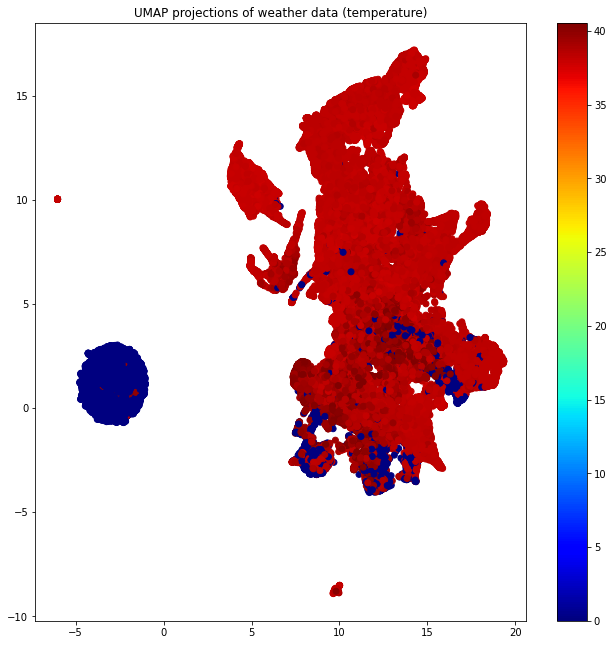

In [38]:
show_temperature(X_train_prj, y_train[indices_for_projections],
                 figure_id=0)

In [39]:
gc.collect()

58984

In [40]:
all_temperatures = sorted(y_train.tolist())
min_temperature = all_temperatures[0]
max_temperature = all_temperatures[-1]
n_samples_in_trainset = len(all_temperatures)
temperature_001 = all_temperatures[int(round(0.001 * n_samples_in_trainset))]
temperature_999 = all_temperatures[int(round(0.999 * n_samples_in_trainset))]
print(f'Minimal temperature is {min_temperature}.')
print(f'Maximal temperature is {max_temperature}.')
print(f'0.1% of temperature is {temperature_001}.')
print(f'99.9% of temperature is {temperature_999}.')
max_temperature = int(np.ceil(temperature_999))
min_temperature = int(np.floor(temperature_001))
n_classes = max_temperature - min_temperature + 1
dict_of_classes = dict()
for class_idx in range(n_classes):
    dict_of_classes[min_temperature + class_idx] = class_idx
print(f'Number of temperature classes is {n_classes}.')
print('They are:')
for temperature_val in dict_of_classes:
    class_idx = dict_of_classes[temperature_val]
    print('  Class {0:>2}: temperature = {1:4.1f}'.format(class_idx, temperature_val))
y_train_class = np.empty(y_train.shape, dtype=np.int64)
for sample_idx in range(y_train.shape[0]):
    temperature_val = int((y_train[sample_idx]))
    if temperature_val in dict_of_classes:
        class_idx = dict_of_classes[temperature_val]
    else:
        if temperature_val < min_temperature:
            class_idx = 0
        else:
            class_idx = n_classes - 1
    y_train_class[sample_idx] = class_idx

Minimal temperature is 0.0.
Maximal temperature is 40.79759216308594.
0.1% of temperature is 0.0.
99.9% of temperature is 40.709651947021484.
Number of temperature classes is 42.
They are:
  Class  0: temperature =  0.0
  Class  1: temperature =  1.0
  Class  2: temperature =  2.0
  Class  3: temperature =  3.0
  Class  4: temperature =  4.0
  Class  5: temperature =  5.0
  Class  6: temperature =  6.0
  Class  7: temperature =  7.0
  Class  8: temperature =  8.0
  Class  9: temperature =  9.0
  Class 10: temperature = 10.0
  Class 11: temperature = 11.0
  Class 12: temperature = 12.0
  Class 13: temperature = 13.0
  Class 14: temperature = 14.0
  Class 15: temperature = 15.0
  Class 16: temperature = 16.0
  Class 17: temperature = 17.0
  Class 18: temperature = 18.0
  Class 19: temperature = 19.0
  Class 20: temperature = 20.0
  Class 21: temperature = 21.0
  Class 22: temperature = 22.0
  Class 23: temperature = 23.0
  Class 24: temperature = 24.0
  Class 25: temperature = 25.0
  Cla

In [41]:
print(f'X_train: dtype = {X_train.dtype}, shape = {X_train.shape}')
print(f'y_train: dtype = {y_train.dtype}, shape = {y_train.shape}')

X_train: dtype = float64, shape = (239666, 20)
y_train: dtype = float64, shape = (239666,)


In [68]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
splitter = skf.split(X_train, y_train_class)
splits = [(train_index, test_index) for train_index, test_index in splitter]
del splitter, skf

In [69]:
postprocessing_scalers = []
deep_ensemble = []
BATCH_SIZE = 4096
MAX_EPOCHS = 1
PATIENCE = 15
new_figure_id = 5
BEST_LAYER_SIZE = 512
best_hyperparams = (18, 3e-4)

In [70]:
gc.collect()
tf.keras.backend.clear_session()

 Self-Normalizing Network 1 for weather prediction

Model: "weather_snn_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 weather_snn_1_feature_vector (  [(None, 20)]        0           []                               
 InputLayer)                                                                                      
                                                                                                  
 weather_snn_1_dropout1 (AlphaD  (None, 20)          0           ['weather_snn_1_feature_vector[0]
 ropout)                                                         [0]']                            
                                                                                                  
 weather_snn_1_dense1 (Dense)   (None, 512)          10752       ['weather_snn_1_dropout1[0][0]'] 
                                  

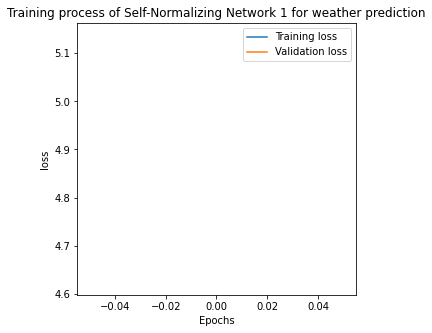

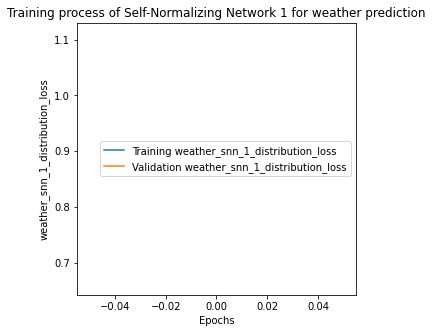

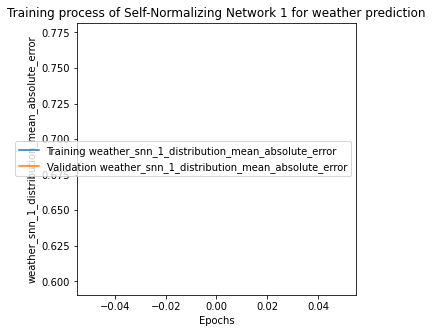


Test quality:
  mean absolute error   = 3.592952088790837
  mean squared error    = 40.011572721618386
  median absolute error = 1.432479278492579
  r2 score              = 0.8835385667174613
  R-AUC MSE             = 19.221601989934918
 Self-Normalizing Network 2 for weather prediction

Model: "weather_snn_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 weather_snn_2_feature_vector (  [(None, 20)]        0           []                               
 InputLayer)                                                                                      
                                                                                                  
 weather_snn_2_dropout1 (AlphaD  (None, 20)          0           ['weather_snn_2_feature_vector[0]
 ropout)                                                         [0]']                       

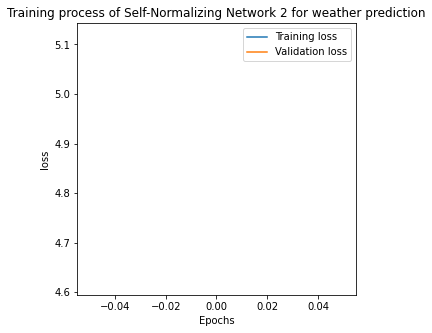

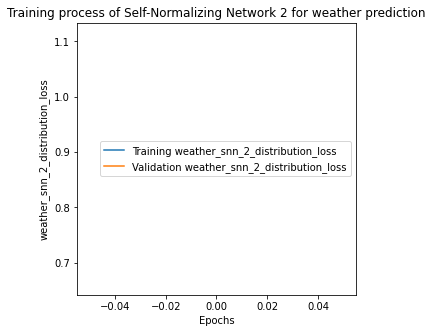

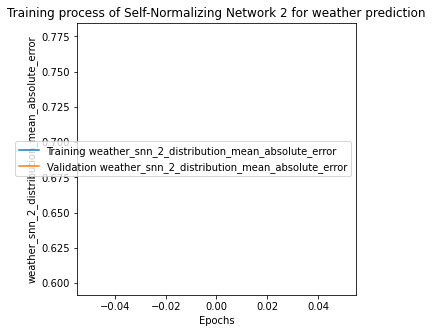


Test quality:
  mean absolute error   = 3.427804917274741
  mean squared error    = 39.02720759371441
  median absolute error = 1.208087866869107
  r2 score              = 0.886390357147285
  R-AUC MSE             = 19.795776947949463


In [71]:
for train_index, test_index in splits:
    model_name = f'weather_snn_{len(deep_ensemble) + 1}'
    serialization_name = os.path.join(model_dir, model_name + '.h5')
    regression_output_name = f'{model_name}_distribution'
    projection_output_name = f'{model_name}_projection'
    printable_name = f'Self-Normalizing Network ' \
                     f'{len(deep_ensemble) + 1} for weather prediction'
    print('========================================')
    print(' ' + printable_name)
    print('========================================')
    print('')
    new_postprocessing_scaler = StandardScaler().fit(
        y_train[train_index].reshape((len(train_index), 1))
    )
    X_train_ = X_train[train_index].astype(np.float32)
    y_train_ = new_postprocessing_scaler.transform(
        y_train[train_index].reshape((len(train_index), 1))
    ).flatten().astype(np.float32)
    y_train_class_ = y_train_class[train_index]
    X_val_ = X_train[test_index].astype(np.float32)
    y_val_ = y_train[test_index]
    y_val_class_ = y_train_class[test_index]
    y_val_scaled_ = new_postprocessing_scaler.transform(
        y_val_.reshape((len(test_index), 1))
    ).flatten().astype(np.float32)
    steps_per_epoch = X_train_.shape[0] // BATCH_SIZE
    postprocessing_scalers.append(new_postprocessing_scaler)
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (
            X_train_,
            (
                y_train_,
                y_train_class_
            )
        )
    ).repeat().shuffle(1000000).batch(BATCH_SIZE)
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (
            X_val_,
            (
                y_val_scaled_,
                y_val_class_
            )
        )
    ).batch(BATCH_SIZE)
    del X_train_, y_train_, y_val_scaled_, y_train_class_, y_val_class_
    new_model = build_neural_network(
        input_size=num_features,
        layer_size=BEST_LAYER_SIZE,
        n_layers=best_hyperparams[0],
        dropout_rate=best_hyperparams[1],
        scale_coeff=new_postprocessing_scaler.scale_[0],
        nn_name=model_name
    )
    new_model.summary()
    print('')
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor=f'val_{regression_output_name}_mean_absolute_error',
            restore_best_weights=True,
            patience=PATIENCE, verbose=True
        )
    ]
    model_history = new_model.fit(
        train_dataset, epochs=MAX_EPOCHS, steps_per_epoch=steps_per_epoch,
        callbacks=callbacks, validation_data=val_dataset, verbose=1
    )
    new_model.save_weights(serialization_name, overwrite=True, save_format='h5')
    del train_dataset, val_dataset
    print('')
    show_training_process(history=model_history, metric_name='loss',
                          figure_id=new_figure_id, comment=printable_name)
    new_figure_id += 1
    show_training_process(history=model_history,
                          metric_name=f'{regression_output_name}_loss',
                          figure_id=new_figure_id, comment=printable_name)
    new_figure_id += 1
    show_training_process(history=model_history,
                          metric_name=f'{regression_output_name}_mean_absolute_error',
                          figure_id=new_figure_id, comment=printable_name)
    new_figure_id += 1
    del model_history, callbacks
    print('')
    deep_ensemble.append(new_model)
    instant_res = predict_with_single_nn(X_val_, new_model, BATCH_SIZE,
                                         output_scaler=new_postprocessing_scaler)
    y_pred_mean = instant_res[0]
    y_pred_var = instant_res[1]
    rauc_mse_score = evaluate_single_nn(y_pred_mean, y_pred_var, y_val_)
    print('Test quality:')
    print(f'  mean absolute error   = {mean_absolute_error(y_val_, y_pred_mean)}')
    print(f'  mean squared error    = {mean_squared_error(y_val_, y_pred_mean)}')
    print(f'  median absolute error = {median_absolute_error(y_val_, y_pred_mean)}')
    print(f'  r2 score              = {r2_score(y_val_, y_pred_mean)}')
    print(f'  R-AUC MSE             = {rauc_mse_score}')
    del X_val_, y_val_
    del new_model

In [72]:
config_name = os.path.join(model_dir, 'weather_snn_config.json')
best_hyperparams_for_saving = {
    'input_size': num_features,
    'ensemble_size': len(splits),
    'layer_size': BEST_LAYER_SIZE,
    'n_layers': best_hyperparams[0],
    'alpha_dropout_rate': best_hyperparams[1]
}
with codecs.open(config_name, mode='w', encoding='utf-8') as fp:
    json.dump(best_hyperparams_for_saving, fp, ensure_ascii=False, indent=4)

In [73]:
preprocessing_name = os.path.join(model_dir, 'preprocessing_pipeline.pkl')
with open(preprocessing_name, 'wb') as fp:
    pickle.dump(common_preprocessor, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [74]:
postprocessing_name = os.path.join(model_dir, 'postprocessing_scalers.pkl')
with open(postprocessing_name, 'wb') as fp:
    pickle.dump(postprocessing_scalers, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
df_in = xr.open_zarr(dev_in_name).to_dataframe().fillna(0)#pd.read_csv(dev_in_name)
print(f'Row number is {df_in.shape[0]}.')
print(f'Column number is {df_in.shape[1]}.')

Row number is 56392.
Column number is 20.


In [76]:
df_out = xr.open_zarr(dev_out_name).to_dataframe().fillna(0)#pd.read_csv(dev_out_name)
print(f'Row number is {df_out.shape[0]}.')
print(f'Column number is {df_out.shape[1]}.')

Row number is 56392.
Column number is 5.


In [77]:
'''inputs = np.vstack([
    df_in.to_numpy().astype(np.float64),
    df_out.to_numpy().astype(np.float64)
])
targets = np.concatenate([
    df_in['fact_temperature'].to_numpy().astype(np.float64),
    df_out['fact_temperature'].to_numpy().astype(np.float64)
])'''

"inputs = np.vstack([\n    df_in.to_numpy().astype(np.float64),\n    df_out.to_numpy().astype(np.float64)\n])\ntargets = np.concatenate([\n    df_in['fact_temperature'].to_numpy().astype(np.float64),\n    df_out['fact_temperature'].to_numpy().astype(np.float64)\n])"

In [78]:
inputs = df_in.to_numpy().astype(np.float64)
targets = df_out.to_numpy().astype(np.float64)
targets = targets[:, 1:2]
targets = targets.ravel()

In [79]:
all_preds = predict_by_ensemble(
    input_data=inputs,
    preprocessing=common_preprocessor,
    postprocessing=postprocessing_scalers,
    ensemble=deep_ensemble,
    minibatch=BATCH_SIZE
)

In [80]:
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

In [81]:
all_preds_mean = all_preds[:,:,0]
avg_preds = np.squeeze(np.mean(all_preds_mean, axis=0))
errors = (avg_preds - targets) ** 2

In [82]:
rejection_mse = calc_uncertainty_regection_curve(errors, uncertainties)
retention_mse = rejection_mse[::-1]
retention_fractions = np.linspace(0, 1, len(retention_mse))

In [83]:
print(f'R-AUC MSE = {np.mean(retention_mse)}.')

R-AUC MSE = 15.49185360865315.


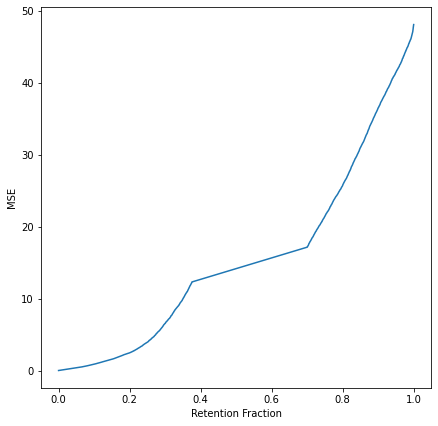

<Figure size 432x288 with 0 Axes>

In [84]:
plt.figure(new_figure_id, figsize=(7, 7))
new_figure_id += 1
plt.plot(retention_fractions, retention_mse)
plt.ylabel('MSE')
plt.xlabel('Retention Fraction')
plt.show()
plt.clf()

In [85]:
thresh = 1.0
f_auc, f95, retention_f1 = f_beta_metrics(errors, uncertainties, thresh, beta=1.0)
print(f'F1 score at 95% retention: {f95}')
retention_fractions = np.linspace(0, 1, len(retention_f1))

F1 score at 95% retention: 0.1504178272835258


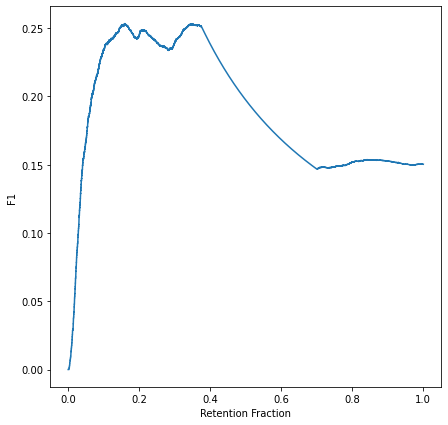

<Figure size 432x288 with 0 Axes>

In [86]:
plt.figure(new_figure_id, figsize=(7, 7))
new_figure_id += 1
plt.plot(retention_fractions, retention_f1)
plt.ylabel('F1')
plt.xlabel('Retention Fraction')
plt.show()
plt.clf()

In [87]:
ids = np.arange(1, inputs.shape[0] + 1)
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
    'ID' : ids,
    'PRED' : preds,
    'UNCERTAINTY' : uncertainties
})

In [88]:
df_submission.head()

,ID,PRED,UNCERTAINTY
0,1,-1.157414,174.329784
1,2,-1.157414,174.329784
2,3,-1.157414,174.329784
3,4,-1.157414,174.329784
4,5,-1.157414,174.329784


In [89]:
out_file = os.path.join(model_dir, 'df_submission_dev.csv')
df_submission.to_csv(out_file, index=False)

In [90]:
df_eval= xr.open_zarr(eval_name).to_dataframe().fillna(0)

In [91]:
eval_inputs = df_eval.to_numpy().astype(np.float64)

In [92]:
all_preds = predict_by_ensemble(
    input_data=eval_inputs,
    preprocessing=common_preprocessor,
    postprocessing=postprocessing_scalers,
    ensemble=deep_ensemble,
    minibatch=BATCH_SIZE
)

In [93]:
all_uncertainty = ensemble_uncertainties_regression(all_preds)
uncertainties = all_uncertainty['tvar']

In [94]:
ids = np.arange(1, len(df_eval) + 1)
preds = np.mean(all_preds[:,:,0], axis=0)
df_submission = pd.DataFrame(data={
    'ID' : ids,
    'PRED' : preds,
    'UNCERTAINTY' : uncertainties
})
df_submission.head()

,ID,PRED,UNCERTAINTY
0,1,-1.157414,174.329784
1,2,-1.157414,174.329784
2,3,-1.157414,174.329784
3,4,-1.157414,174.329784
4,5,-1.157414,174.329784


In [95]:
out_file = os.path.join(model_dir, 'df_submission.csv')
df_submission.to_csv(out_file, index=False)